In [2]:
import paramiko
import getpass
import numpy as np
import imrt

In [3]:
ssh = imrt.connect("158.251.88.197")

login: iaraya
pass: ········


----
Constructor imrt
---

Se carga la instancia remotamente generando las estructuras necesarias para ser usada. `max_voxels` es la cantidad máxima de voxels que se usa para representar un órgano. Limitar la cantidad permite probar los algoritmos más rápidamente.

Además carga localmente información de las instancias:

* cantidad de voxels por órgano (`nvoxels`)
* lista de ángulos (`angles`)
* cantidad de beamlets y valid shapes por ángulos (`angle2nbeamlets`)

In [4]:
instance = imrt.imrt("/home/iaraya/imrt", ["data/Equidistantes/equidist.txt", "data/Equidistantes/equidist-coord.txt"], ssh, max_voxels=500, port=8050)

killall DAO_ILS; /home/iaraya/imrt/DAO_ILS --files-dep=data/Equidistantes/equidist.txt --file-coord=data/Equidistantes/equidist-coord.txt --tabu-size=200 --seed=3 --min_impr=0.05 --vsize=0.002 --max_voxels=500 --path=/home/iaraya/imrt --port=8050
ready



----
init_fluence_map
--

Carga el fluence map con el BAC (beam angle configuration) asociado.
Retorna la evaluación correspondiente.

In [5]:
instance.init_fluence_map(fluence_map=[], bac=[0, 175, 245, 315])

echo init_fluence_map 4 0 175 245 315  | netcat localhost 8050


28880.0

----
iterated_local_search (`DAO_ILS`)
---

Realiza una búsqueda local usando dos vecindarios y retorna la evaluación de la solución encontrada (y la cantidad de iteraciones realizada). Usa los siguientes tipos de movimiento:

* *beam_intensity move*: modifica un beamlet de un fluence map matrix (existe la opción *targeted* para ordenar los movimientos)
* *level_intensity move*: modifica un nivel de intensidad de la matriz

In [6]:
instance.iterated_local_search()

(37.6712, 3622)

In [28]:
D = dict()
D[0] = instance.get_deposition_matrix(0, 0)
D[1] = instance.get_deposition_matrix(0, 100)
D[2] = instance.get_deposition_matrix(0, 200)

In [29]:
vect=instance.get_dose_vectors()

In [34]:
import networkx as nx
G = nx.empty_graph(500)

for vox in range(500):
    v0 = np.max(D[0][vox]); v1 = np.max(D[1][vox]); v2 = np.max(D[2][vox])

    b0 = np.argmax(D[0][vox])
    b1 = np.argmax(D[1][vox])
    b2 = np.argmax(D[2][vox])
    [b0,b1,b2] # beamlets 
    [v0,v1,v2] # values beamlets
    #nodes= []
    for i in range(0,500):
        #if D[0][i][b0]<=0.01 or D[1][i][b1]<=0.01 or D[2][i][b2]<=0.01: continue
        if v0*0.05 <= D[0][i][b0] <= v0*20 and \
        v1*0.05 <= D[1][i][b1] <= v1*20 and \
        v2*0.05 <= D[2][i][b2] <= v2*20:
            if vox != i:
                G.add_edge(vox,i)
                #nodes.append(i)


In [35]:
color_map=[]
for i in range(len(vect[2])):
    if vect[2][i]>77:
        color_map.append('#%02x%02x%02x' % (255,0,0))
    elif vect[2][i]<75:
        color_map.append('#%02x%02x%02x' % (0,0,255))
    else:
        color_map.append('#%02x%02x%02x' % (0,255,0))

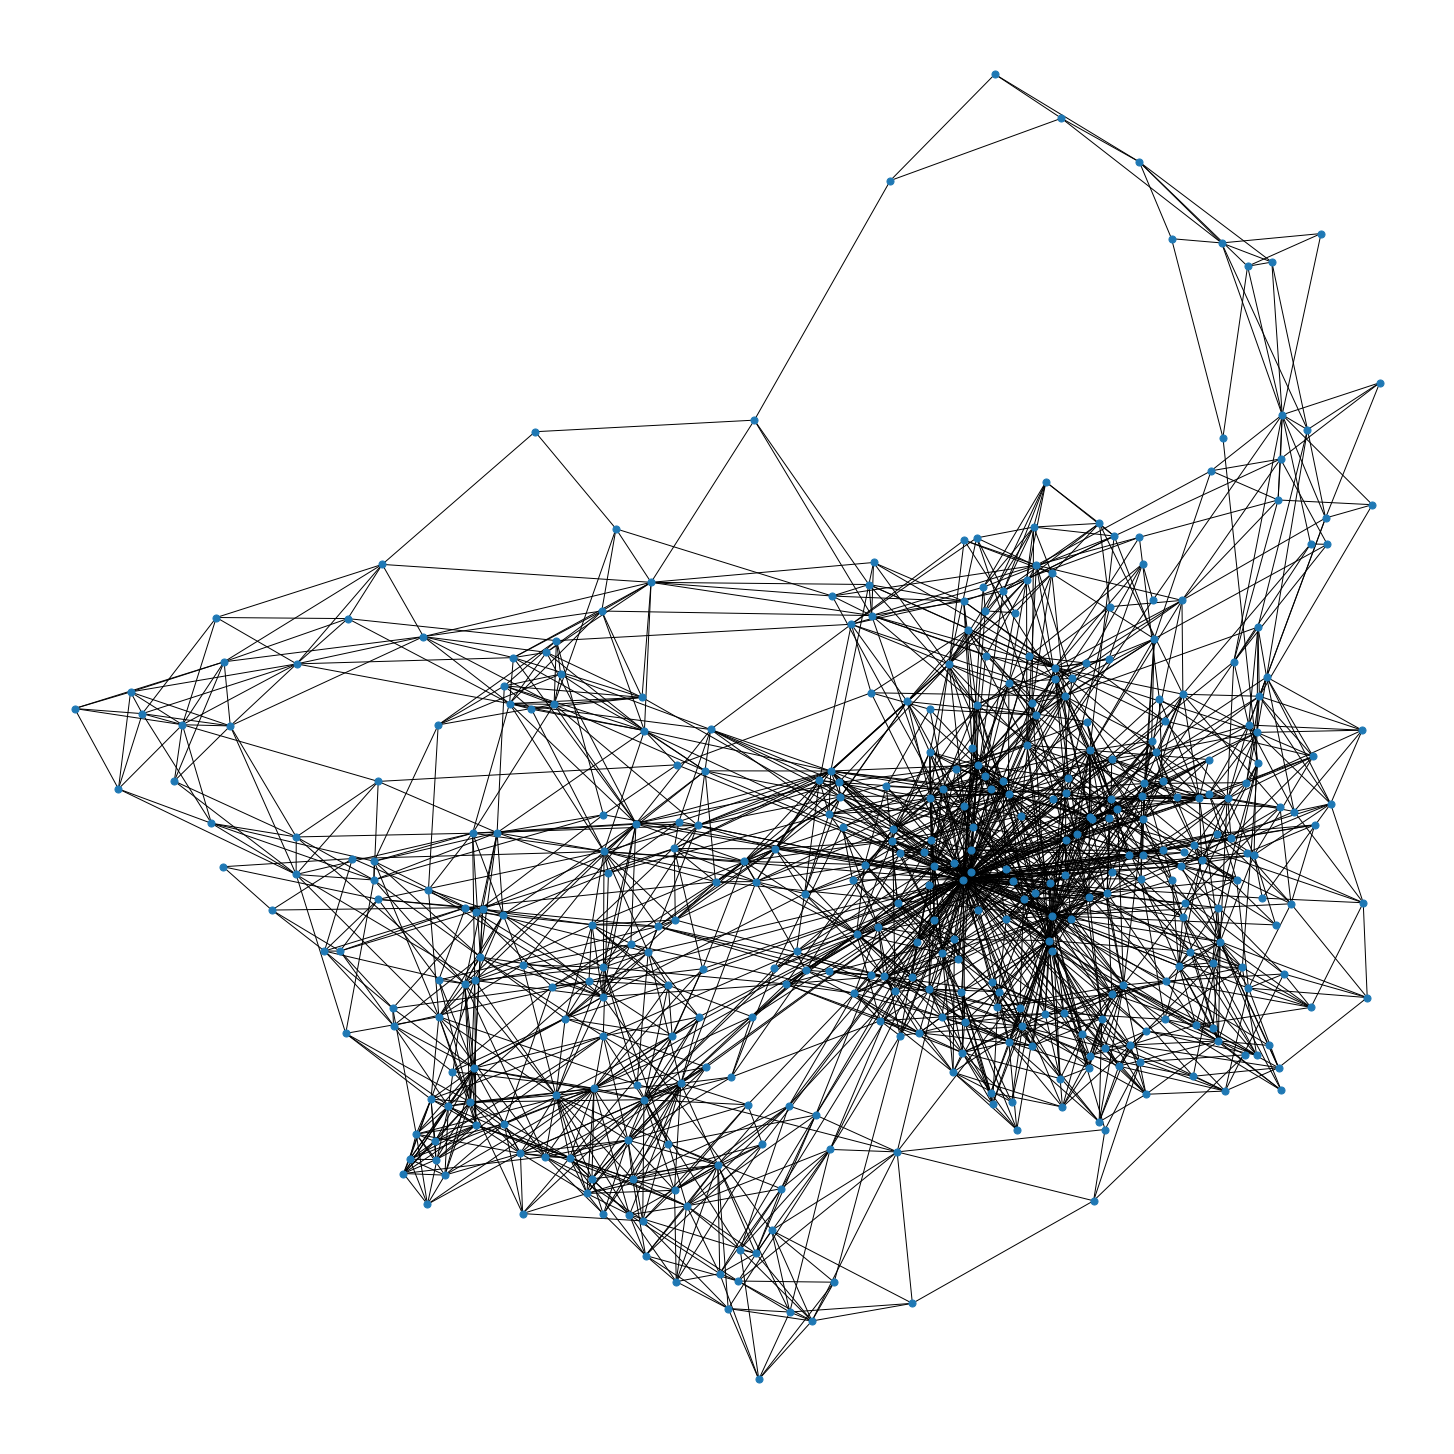

In [36]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

to_remove = []
for node in G:
    if len(list(G.neighbors(node))) < 5:
        to_remove.append(node)

for node in to_remove:
    G.remove_node(node)
pos = nx.spring_layout(G)
plt.figure(3,figsize=(20,20))
nx.draw(G, pos, node_size=50)
#nx.draw(G, pos, node_color=color_map, node_size=50)
plt.show() 